In [28]:
import pandas as pd
from tabulate import tabulate


def print_df(df, n=10):
    df_to_print = df.iloc[:n, :n]
    print(tabulate(df_to_print.head(n), headers='keys', tablefmt='psql'))


df = pd.read_csv('data/ratings.csv')
ratings_matrix = df.pivot(index='userId', columns='movieId', values='rating')
print_df(ratings_matrix)

+----------+-------+-----+-----+-----+-----+-----+-----+-----+-----+------+
|   userId |     1 |   2 |   3 |   4 |   5 |   6 |   7 |   8 |   9 |   10 |
|----------+-------+-----+-----+-----+-----+-----+-----+-----+-----+------|
|        1 |   4   | nan |   4 | nan | nan |   4 | nan | nan | nan |  nan |
|        2 | nan   | nan | nan | nan | nan | nan | nan | nan | nan |  nan |
|        3 | nan   | nan | nan | nan | nan | nan | nan | nan | nan |  nan |
|        4 | nan   | nan | nan | nan | nan | nan | nan | nan | nan |  nan |
|        5 |   4   | nan | nan | nan | nan | nan | nan | nan | nan |  nan |
|        6 | nan   |   4 |   5 |   3 |   5 |   4 |   4 |   3 | nan |    3 |
|        7 |   4.5 | nan | nan | nan | nan | nan | nan | nan | nan |  nan |
|        8 | nan   |   4 | nan | nan | nan | nan | nan | nan | nan |    2 |
|        9 | nan   | nan | nan | nan | nan | nan | nan | nan | nan |  nan |
|       10 | nan   | nan | nan | nan | nan | nan | nan | nan | nan |  nan |
+----------+

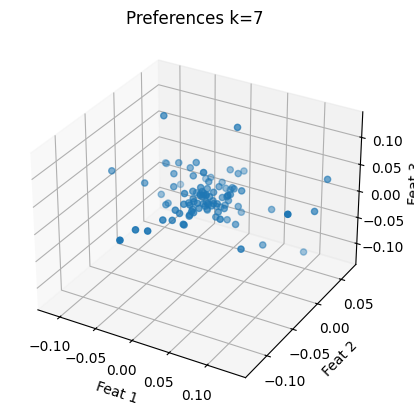

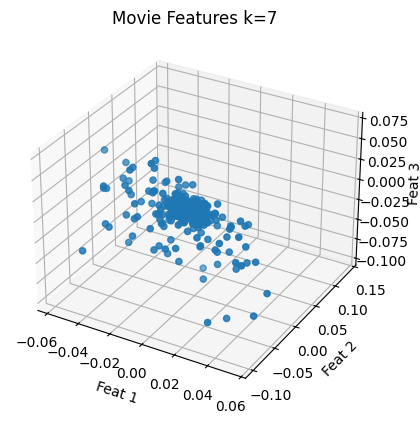

In [29]:
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
import numpy as np

class SvdResult:
    def __init__(self, u, sigma, v_t):
        self.u = u
        self.sigma = sigma
        self.v_t = v_t


def do_svd(r_demeaned, k):
    u, sigma, v_t = svds(r_demeaned, k=k)
    # print(u)

    u_subset = u[:100, :]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(u_subset[:, 0], u_subset[:, 1], u_subset[:, 2], marker='o')
    ax.set_title(f'Preferences k={k}')
    ax.set_xlabel('Feat 1')
    ax.set_ylabel('Feat 2')
    ax.set_zlabel('Feat 3')
    plt.show()

    vt_subset = v_t.T[:500, :]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(vt_subset[:, 0], vt_subset[:, 1], vt_subset[:, 2], marker='o')
    ax.set_title(f'Movie Features k={k}')
    ax.set_xlabel('Feat 1')
    ax.set_ylabel('Feat 2')
    ax.set_zlabel('Feat 3')
    plt.show()
    return SvdResult(u, sigma, v_t)

ratings_matrix_filled = ratings_matrix.fillna(2.5)
R = ratings_matrix_filled.values
user_ratings_mean = np.mean(R, axis=1)
R_demeaned = R - user_ratings_mean.reshape(-1, 1)

svd_result = do_svd(R_demeaned, 7)

In [30]:
def compute_predicted_ratings(u, sigma, v_t):
    all_user_predicted_ratings = np.dot(np.dot(u, sigma), v_t) + user_ratings_mean.reshape(-1, 1)
    predicts_df = pd.DataFrame(all_user_predicted_ratings, columns=ratings_matrix.columns, index=ratings_matrix.index)
    return predicts_df
    
predictions_df = compute_predicted_ratings(svd_result.u, np.diag(svd_result.sigma), svd_result.v_t)
print_df(predictions_df)

+----------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+
|   userId |       1 |       2 |       3 |       4 |       5 |       6 |       7 |       8 |       9 |      10 |
|----------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------|
|        1 | 3.70461 | 2.84759 | 2.77914 | 2.49681 | 2.58889 | 3.47546 | 2.58218 | 2.51998 | 2.52002 | 3.44993 |
|        2 | 2.53732 | 2.55433 | 2.47595 | 2.50147 | 2.50058 | 2.5495  | 2.4917  | 2.50344 | 2.49771 | 2.49127 |
|        3 | 2.41602 | 2.47403 | 2.47979 | 2.50219 | 2.49195 | 2.5201  | 2.47279 | 2.50082 | 2.50051 | 2.52155 |
|        4 | 3.05761 | 2.56769 | 2.53511 | 2.49626 | 2.42675 | 2.55715 | 2.47926 | 2.48292 | 2.48475 | 2.44746 |
|        5 | 2.93018 | 2.73403 | 2.66312 | 2.5101  | 2.62596 | 2.72915 | 2.65429 | 2.53192 | 2.52971 | 2.71471 |
|        6 | 3.94381 | 3.48694 | 3.18743 | 2.56133 | 3.027   | 3.19792 | 3.11048 | 2.65657 | 2.6

In [31]:
def remove_original_ratings(preds_df, original_df):
    preds_only_df = preds_df.copy()
    mask = ~original_df.isna()
    preds_only_df[mask] = np.nan
    return preds_only_df


preds_only_df_res = remove_original_ratings(predictions_df, ratings_matrix)
print_df(preds_only_df_res)

+----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+---------+-----------+
|   userId |         1 |         2 |         3 |         4 |         5 |         6 |         7 |         8 |       9 |        10 |
|----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+---------+-----------|
|        1 | nan       |   2.84759 | nan       |   2.49681 |   2.58889 | nan       |   2.58218 |   2.51998 | 2.52002 |   3.44993 |
|        2 |   2.53732 |   2.55433 |   2.47595 |   2.50147 |   2.50058 |   2.5495  |   2.4917  |   2.50344 | 2.49771 |   2.49127 |
|        3 |   2.41602 |   2.47403 |   2.47979 |   2.50219 |   2.49195 |   2.5201  |   2.47279 |   2.50082 | 2.50051 |   2.52155 |
|        4 |   3.05761 |   2.56769 |   2.53511 |   2.49626 |   2.42675 |   2.55715 |   2.47926 |   2.48292 | 2.48475 |   2.44746 |
|        5 | nan       |   2.73403 |   2.66312 |   2.5101  |   2.62596 |   2.72915 

In [32]:
movies_df = pd.read_csv('data/movies.csv')


def get_recommendations(user_id, predicts_df, movies_df, n=10):
    sorted_user_predictions = predicts_df.iloc[user_id - 1].sort_values(ascending=False)

    recommendations = (movies_df[movies_df['movieId'].isin(sorted_user_predictions.index)]
                       .set_index('movieId')
                       .loc[sorted_user_predictions.index]
                       .assign(predicted_rating=sorted_user_predictions.values)
                       .sort_values('predicted_rating', ascending=False))

    return recommendations.head(n)


user_id = 1
user_recommendations = get_recommendations(user_id, preds_only_df_res, movies_df)
print(tabulate(user_recommendations, headers='keys', tablefmt='psql'))

+-----------+-------------------------------------------+--------------------------------+--------------------+
|   movieId | title                                     | genres                         |   predicted_rating |
|-----------+-------------------------------------------+--------------------------------+--------------------|
|       589 | Terminator 2: Judgment Day (1991)         | Action|Sci-Fi                  |            4.73008 |
|      1200 | Aliens (1986)                             | Action|Adventure|Horror|Sci-Fi |            4.40771 |
|      1036 | Die Hard (1988)                           | Action|Crime|Thriller          |            4.09477 |
|       541 | Blade Runner (1982)                       | Action|Sci-Fi|Thriller         |            4.00168 |
|        32 | Twelve Monkeys (a.k.a. 12 Monkeys) (1995) | Mystery|Sci-Fi|Thriller        |            3.92355 |
|      1527 | Fifth Element, The (1997)                 | Action|Adventure|Comedy|Sci-Fi |            3.